# Pattern Recognition 1 - Expert System

**Objectives**

* Create a working image analysis and pattern recognition pipeline
* Object labelisation and feature extraction
* Creating an Expert System for Optical Character Recognition (OCR)

**Libraries needed for this lab**

* Numpy
* Matplotlib
* Scikit-image

(all included in the Anaconda distribution)

## Object detection

Given the following image :

(851, 1068) uint8


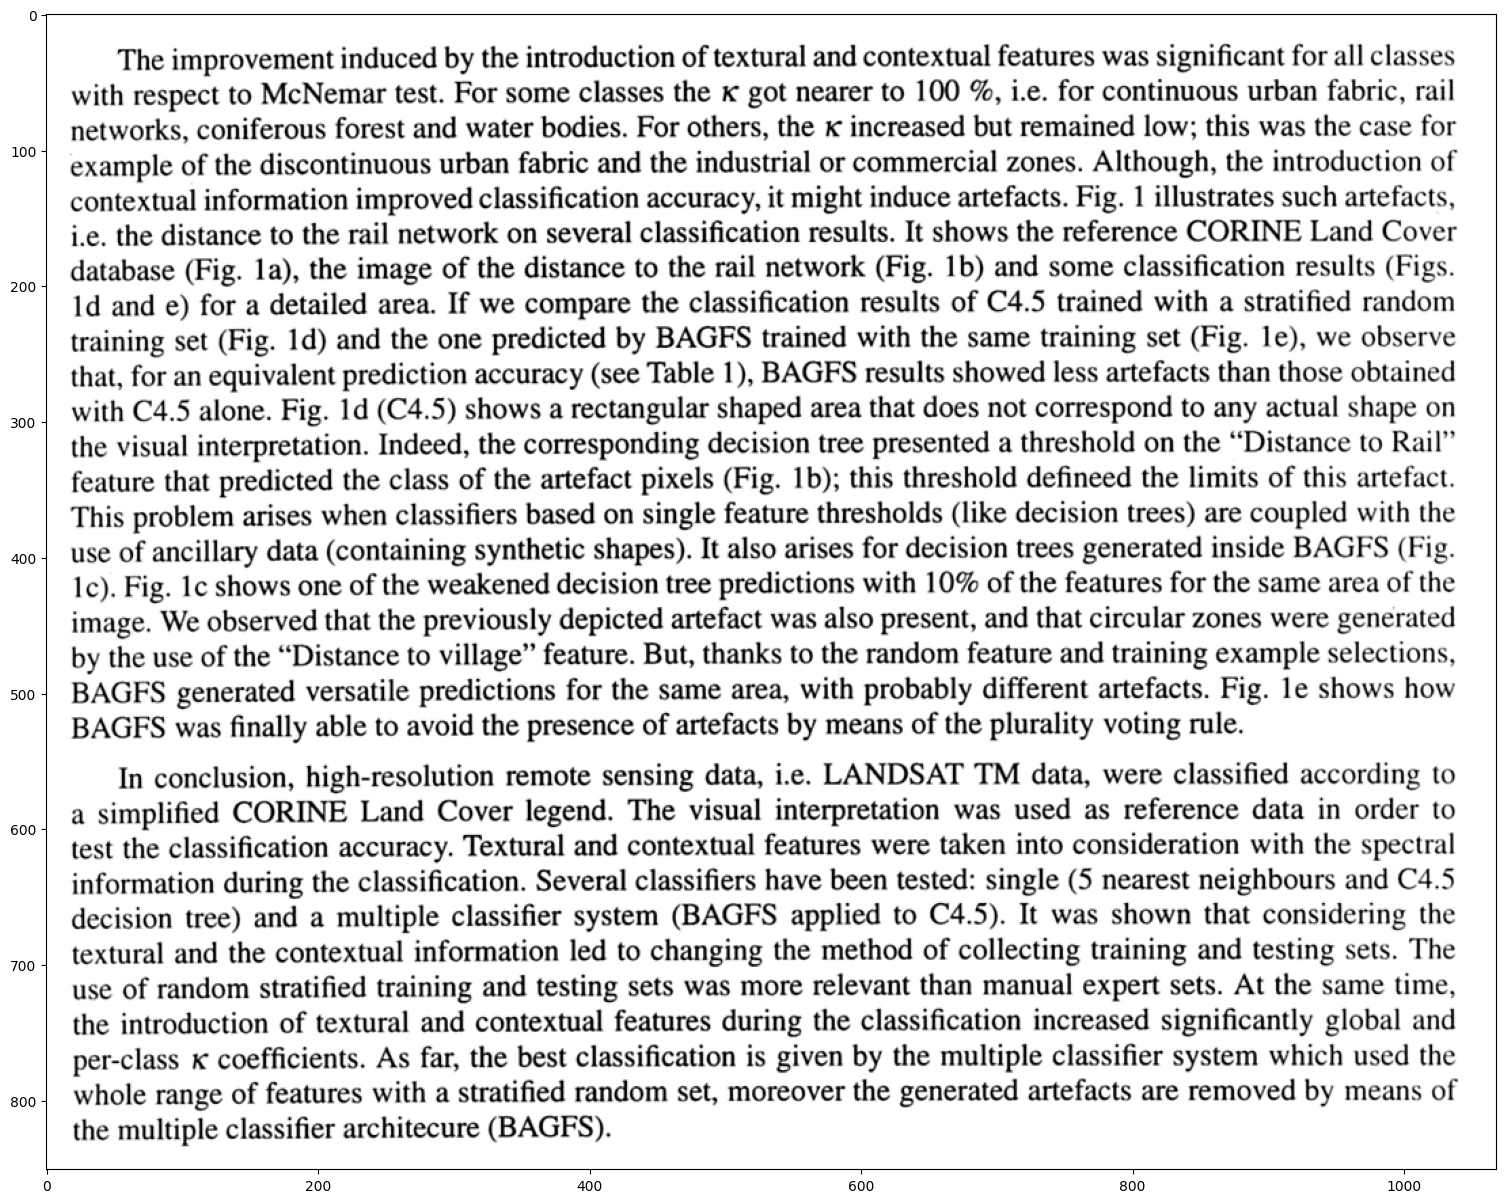

In [42]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
%matplotlib inline

im = imread(r'C:\Users\gianm\Documents\Uni\Big Data\H501\exercises\Data\doc1.png')
print(im.shape, im.dtype)

plt.figure(figsize=(20,15))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

* **Segment** the image to isolate the text from the background
* **Label individual characters** and **extract** the centroid position, the bounding box, and useful features for each character.

Useful documentation: [`skimage.measure`](http://scikit-image.org/docs/dev/api/skimage.measure.html) module.

Image intensity range: 0 to 255


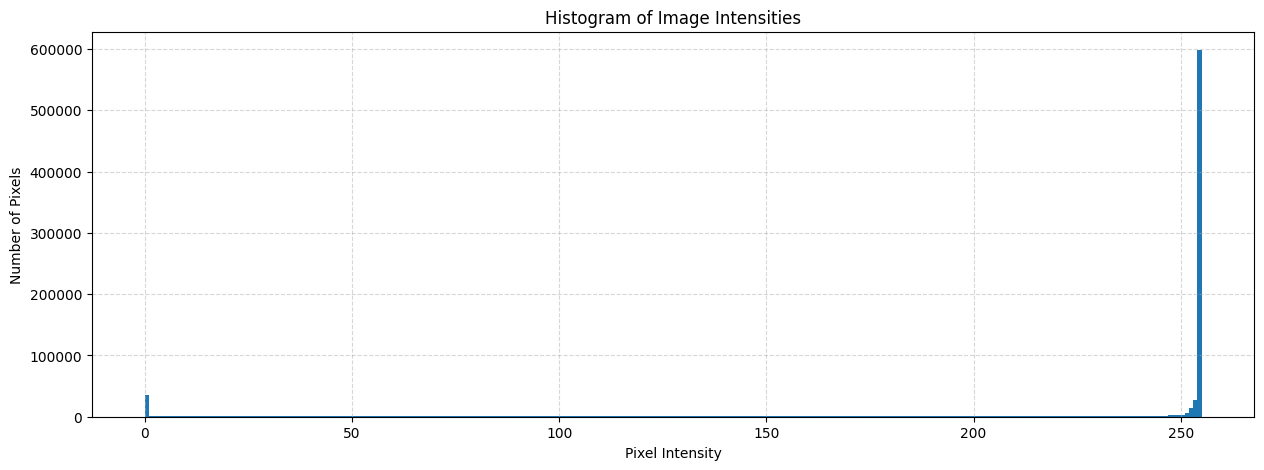

In [3]:
# report the grayscale intensity range
print("Image intensity range:", im.min(), "to", im.max())

# plot the histogram of pixel values
plt.figure(figsize=(15,5))
plt.hist(
    im.flatten(), bins=255
)
plt.title("Histogram of Image Intensities")
plt.xlabel("Pixel Intensity")
plt.ylabel("Number of Pixels")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

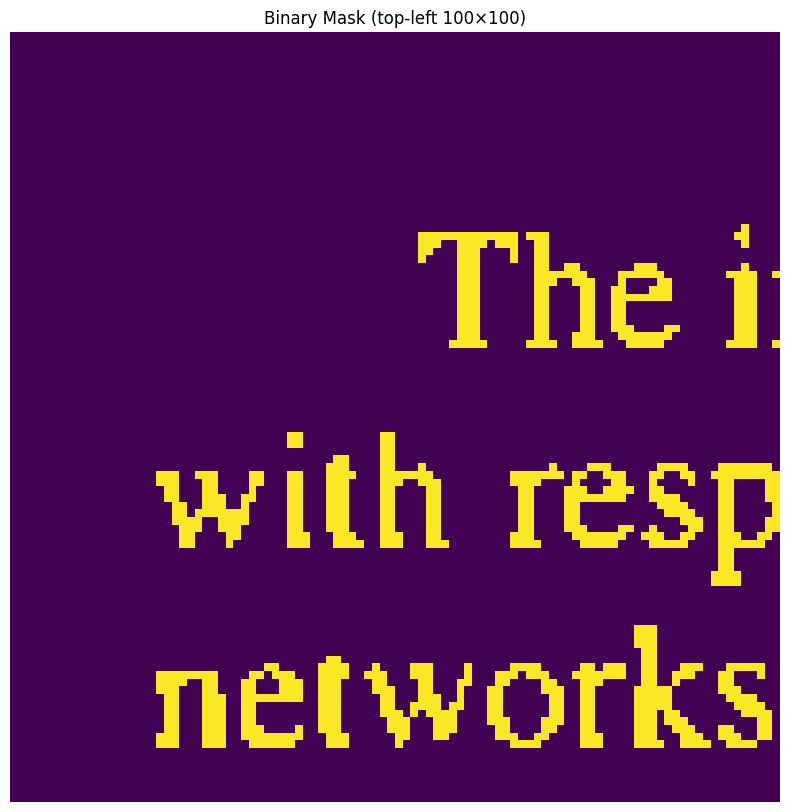

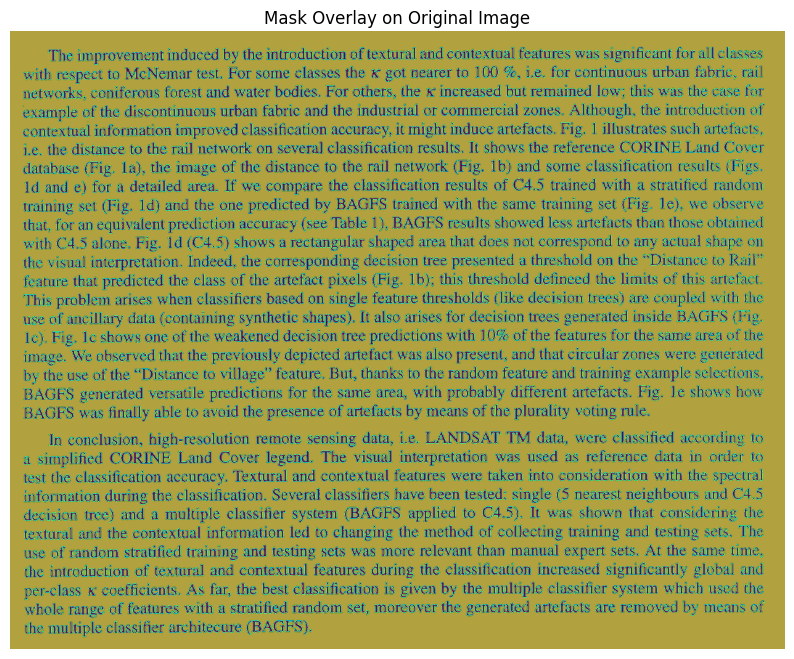

In [6]:
# binary segmentation based on a fixed threshold
segmented = im<150

# visualize the top-left corner of the mask alone
plt.figure(figsize=(10,10))
plt.imshow(segmented[:100, :100])
plt.title("Binary Mask (top-left 100×100)")
plt.axis('off')
plt.show()

# overlay the mask on the original for context
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.imshow(segmented, cmap='jet', alpha=0.3)
plt.title("Mask Overlay on Original Image")
plt.axis('off')
plt.show()

Detected 3066 connected components (objects)


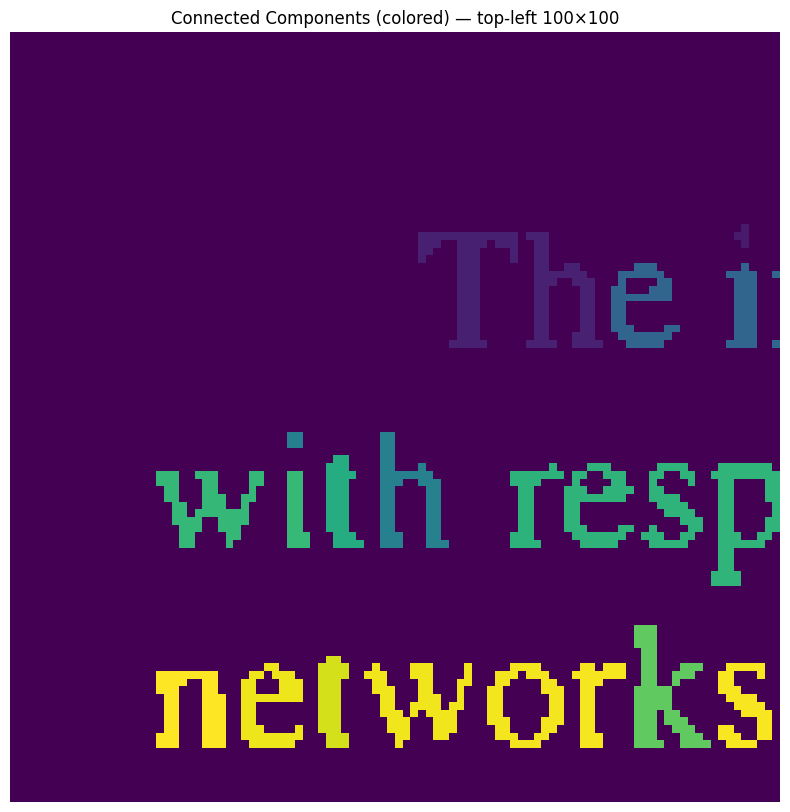

In [8]:
# Instance segmentation via connected components: pixels part of the same object if they're connected together
from skimage.measure import label

# label each connected region (8-connectivity)
label_image = label(segmented)

# report how many components were found
n_objects = label_image.max()
print(f"Detected {n_objects} connected components (objects)")

# visualize a small patch with each label in a distinct color
plt.figure(figsize=(10,10))
plt.imshow(label_image[:100, :100])
plt.title("Connected Components (colored) — top-left 100×100")
plt.axis('off')
plt.show()

(np.float64(30.142857142857142), np.float64(692.5142857142857)) (22, 691, 38, 695)
Centroid (row, col): (np.float64(30.142857142857142), np.float64(692.5142857142857))
Bounding box (min_row, min_col, max_row, max_col): (22, 691, 38, 695)


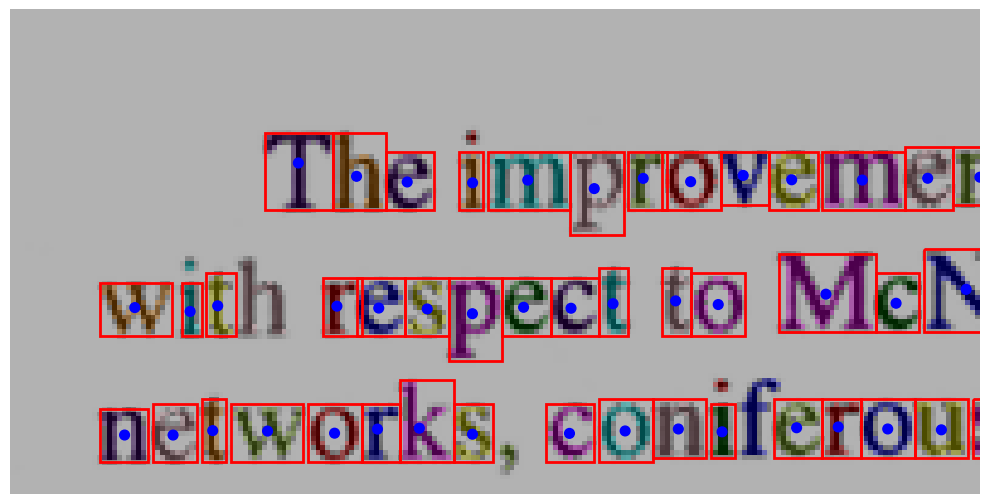

In [14]:
# find the position of each characters in terms of position to centroid and bounding box
from skimage.measure import regionprops
from skimage.color import label2rgb
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# compute region properties
regions = regionprops(label_image)

# print out the first region’s centroid & bbox as a sanity check
r0 = regions[0]
print("Centroid (row, col):", r0.centroid)
print("Bounding box (min_row, min_col, max_row, max_col):", r0.bbox)

image_label_overlay = label2rgb(label_image, image=im, bg_label=0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_label_overlay[0:100, 0:200])

for region in regions:
    # take regions with large enough areas
    if np.sum(region.image) > 10:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        minr -= 1
        minc -= 1
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor='red',
            linewidth=2,
        )
        centroid = region.centroid
        circ = mpatches.Circle(
            (centroid[1], centroid[0]),
            radius=1,
            color='blue'
        )
    
        ax.add_patch(circ)
        ax.add_patch(rect)
    else:
        regions.remove(region)

ax.set_axis_off()
plt.tight_layout()
plt.show()

## Line detection and letter ordering

* Find the labels (objects) that belong to each text line
* Order each character in a text line from left to right

Detected maxima at rows: [32, 58, 84, 110, 136, 162, 187, 213, 239, 265, 291, 316, 342, 368, 394, 421, 446, 472, 498, 524, 561, 587, 613, 638, 664, 690, 716, 742, 769, 794, 822]


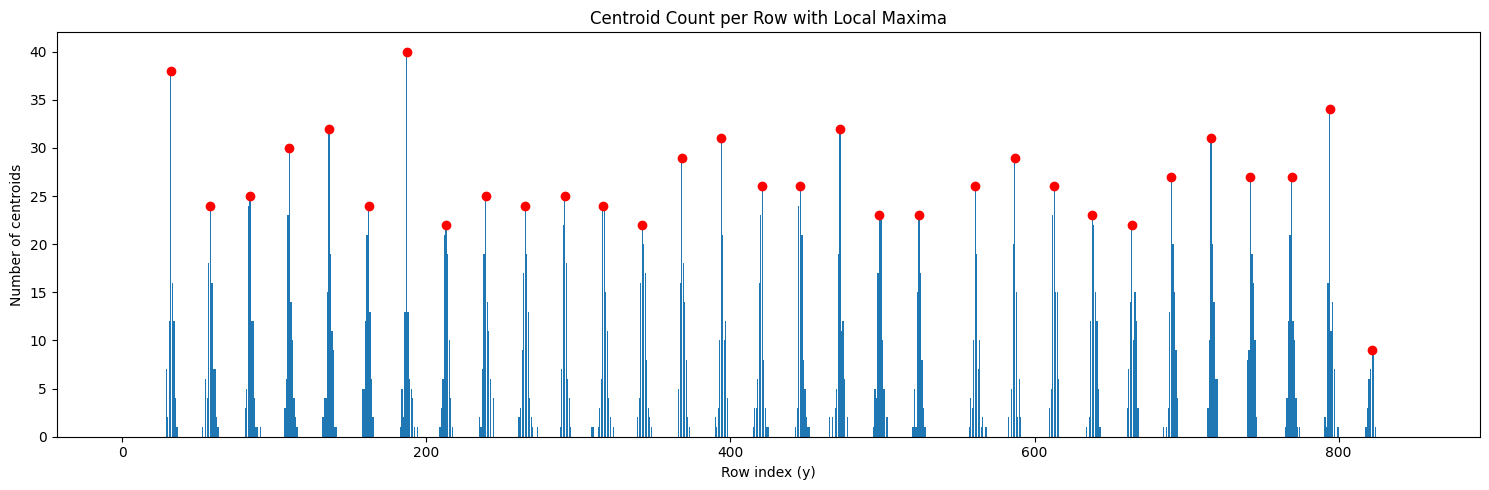

In [31]:
# compute a histogram of object centroids along the y-axis
centroid_counts = np.zeros(im.shape[0], dtype=int)

# count centroids of sufficiently large regions
for region in regions:
    if region.area < 10:
        continue
    y_centroid = int(region.centroid[0])
    centroid_counts[y_centroid] += 1

# find local maxima in the centroid histogram
maxima = []
window = 3
threshold = 5

for y in range(window, im.shape[0] - window):
    window_slice = centroid_counts[y - window : y + window + 1]
    if (centroid_counts[y] == window_slice.max() 
        and centroid_counts[y] > threshold 
        and (y - 1) not in maxima):
        maxima.append(y)

print("Detected maxima at rows:", maxima)

# plot the histogram and highlight maxima
plt.figure(figsize=(15, 5))
plt.bar(np.arange(im.shape[0]), centroid_counts)
plt.scatter(maxima, [centroid_counts[y] for y in maxima], color='red', zorder=5)
plt.title("Centroid Count per Row with Local Maxima")
plt.xlabel("Row index (y)")
plt.ylabel("Number of centroids")
plt.tight_layout()
plt.show()

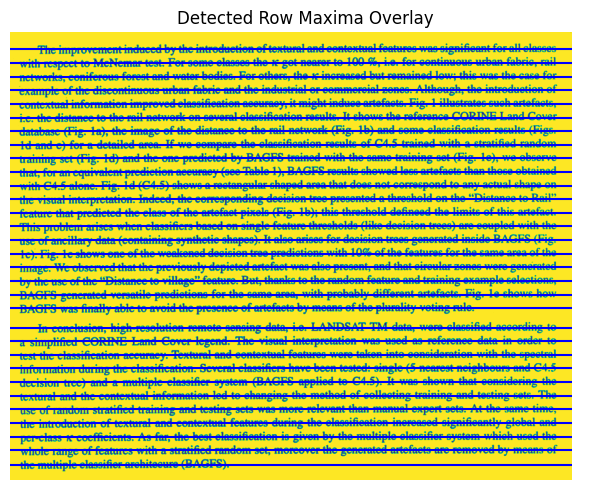

In [32]:
# visualize image with horizontal lines at detected maxima
plt.figure(figsize=(10, 5))
plt.imshow(im)
plt.title("Detected Row Maxima Overlay")
plt.axis('off')

# draw horizontal lines at each detected maxima row
for m in maxima:
    plt.hlines(
        y=m,
        xmin=0,
        xmax=im.shape[1],
        colors='b',
        linewidth=1.5,
        linestyles='-'
    )

plt.tight_layout()
plt.show()

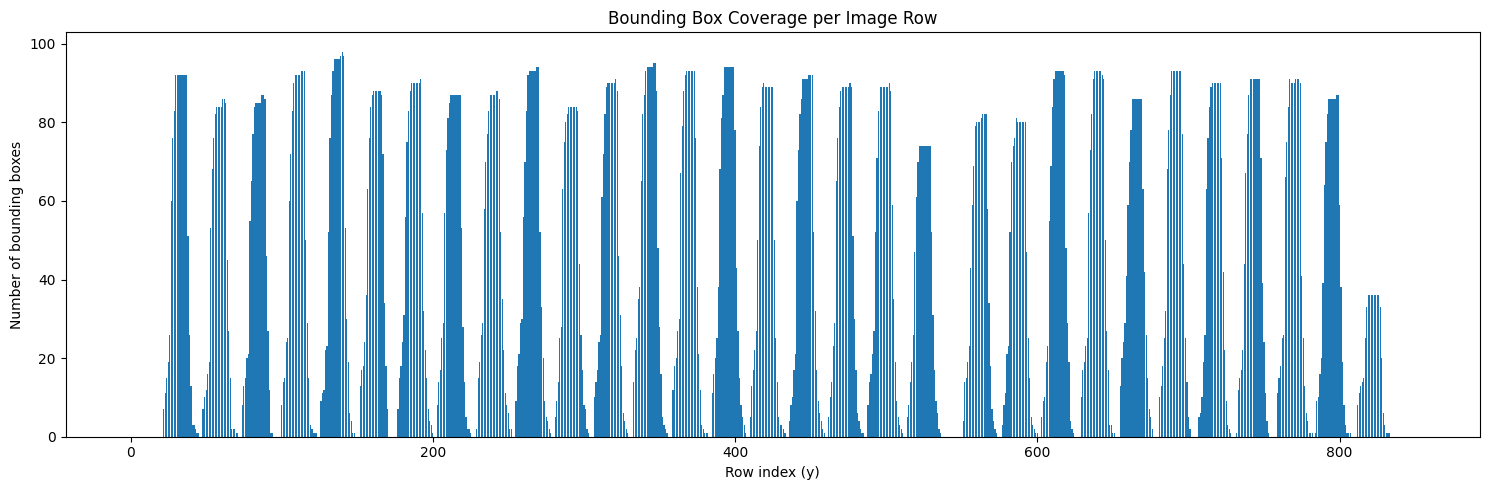

In [33]:
# compute vertical histogram of bounding‐box coverage
bbox_counts = np.zeros(im.shape[0], dtype=int)

for region in regions:
    # skip small regions
    if region.area < 10:
        continue
    minr, minc, maxr, maxc = region.bbox
    # increment each row within the bounding box
    bbox_counts[minr:maxr] += 1

# plot the bounding‐box coverage per row
plt.figure(figsize=(15, 5))
plt.bar(
    np.arange(im.shape[0]),
    bbox_counts
)
plt.title("Bounding Box Coverage per Image Row")
plt.xlabel("Row index (y)")
plt.ylabel("Number of bounding boxes")
plt.tight_layout()
plt.show()

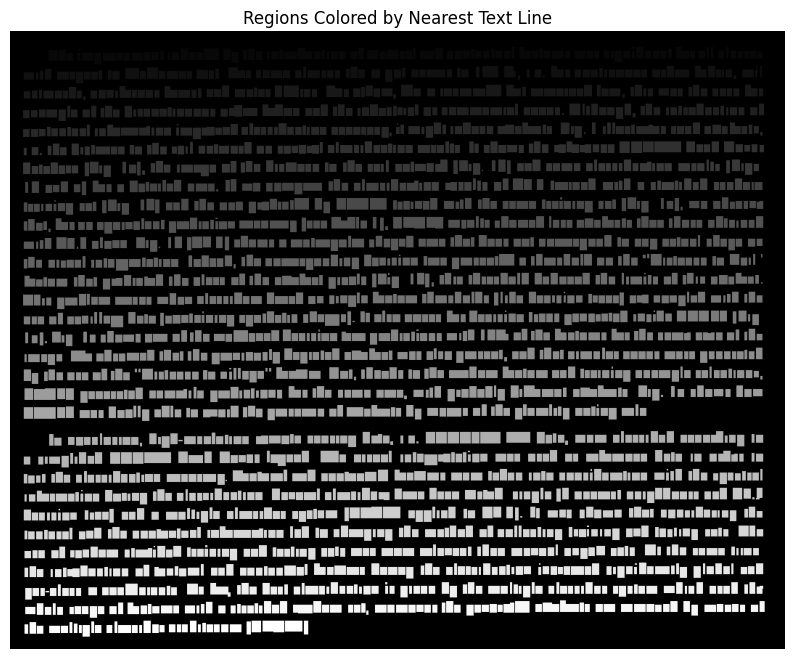

In [34]:
# map each detected region to its nearest baseline (from `maxima`)
num_lines = len(maxima)
line_groups = [[] for _ in range(num_lines)]
maxima_arr = np.array(maxima)

# create an integer image where each pixel’s value is the 1-based line index
line_image = np.zeros_like(im, dtype=int)

for region in regions:
    # find closest line by vertical distance from the region’s centroid
    y_centroid = region.centroid[0]
    line_idx = np.abs(maxima_arr - y_centroid).argmin()
    line_groups[line_idx].append(region)

    # paint the region’s bounding box in the line_image
    minr, minc, maxr, maxc = region.bbox
    line_image[minr:maxr, minc:maxc] = line_idx + 1

# plot
plt.figure(figsize=(10, 10))
plt.imshow(line_image, cmap=plt.cm.gray)
plt.title("Regions Colored by Nearest Text Line")
plt.axis('off')
plt.show()

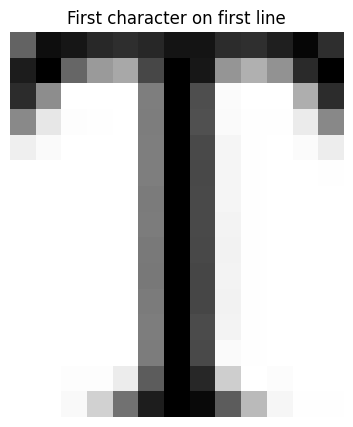

In [28]:
# order regions by text line (row) and reading order (left→right)

# prepare an empty list per detected text line
ordered_regions = [[] for _ in range(len(maxima))]

for line_idx, regions_on_line in enumerate(line_groups):
    # Get the x-coordinates of each region’s centroid
    x_centroids = np.array([r.centroid[1] for r in regions_on_line])
    # Sort indices by increasing x (left to right)
    sort_idx = np.argsort(x_centroids)
    # Reorder and store
    ordered_regions[line_idx] = [regions_on_line[i] for i in sort_idx]

# sanity-check: display the first character of the first line
first_region = ordered_regions[0][0]
minr, minc, maxr, maxc = first_region.bbox

plt.figure(figsize=(5, 5))
plt.imshow(im[minr:maxr, minc:maxc], cmap='gray')
plt.title("First character on first line")
plt.axis('off')
plt.show()

## Expert System classification

* Using the features available with the [regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) method of scikit-image, propose a method to automatically recognize some letters.

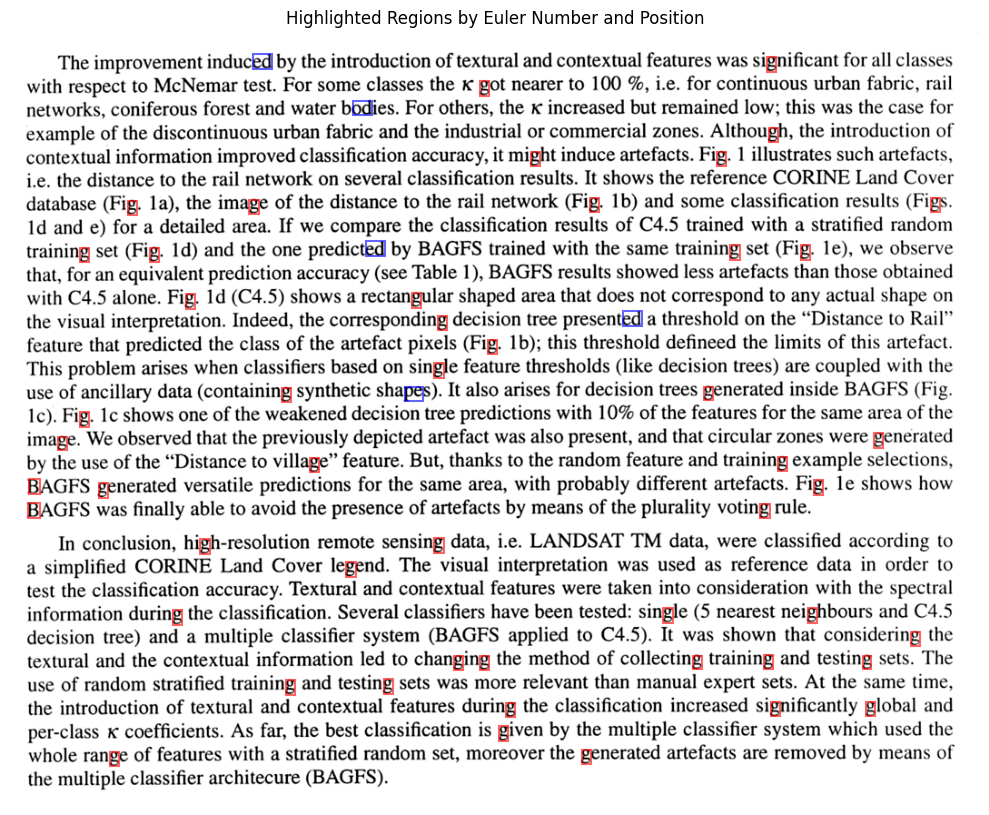

In [36]:
# set up figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(im, cmap='gray')
ax.axis('off')
ax.set_title("Highlighted Regions by Euler Number and Position")

# loop over each text line and its regions
for line_idx, regions in enumerate(ordered_regions):
    baseline_y = maxima[line_idx]

    for region in regions:
        minr, minc, maxr, maxc = region.bbox  # (row_start, col_start, row_end, col_end)

        # only consider regions with Euler = -1 below the baseline
        if region.euler_number == -1 and region.centroid[0] > baseline_y:
            width  = maxc - minc
            height = maxr - minr

            # narrow regions get red; others get blue
            color = 'red' if width < 15 else 'blue'
        else:
            continue

        # draw the bounding box
        rect = Rectangle(
            (minc, minr),     # (x, y) = (col, row)
            width,
            height,
            linewidth=1.5,
            edgecolor=color,
            facecolor='none',
            alpha=0.6
        )
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

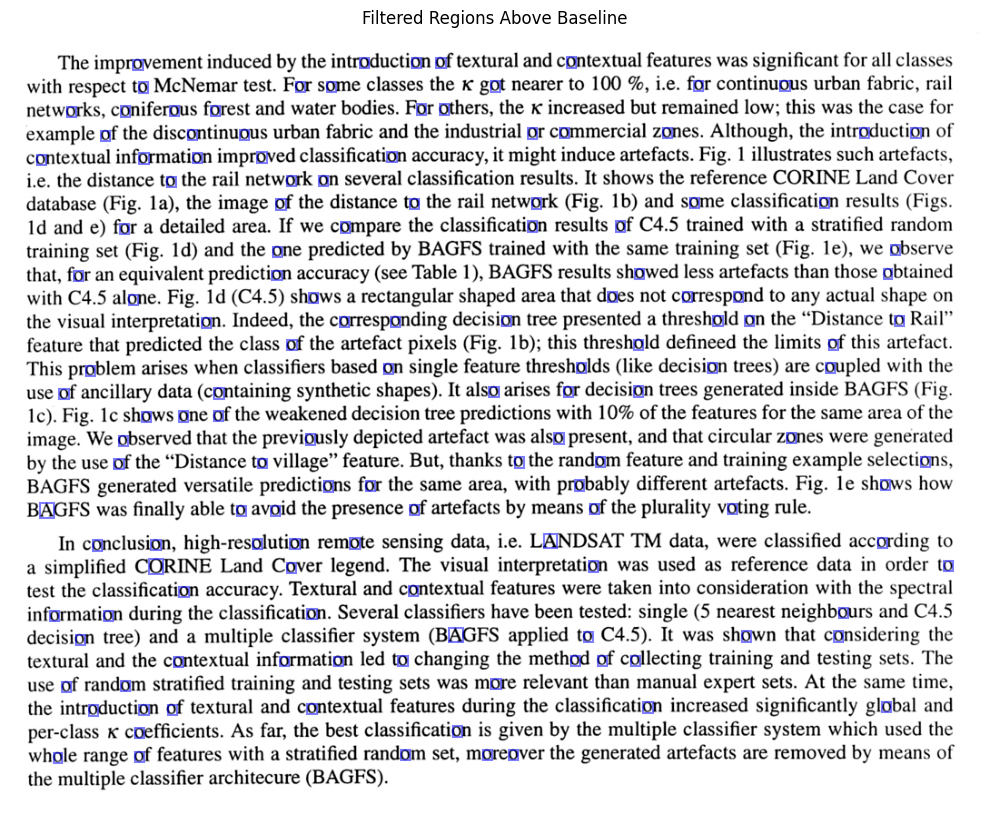

In [39]:
# display the image
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(im, cmap='gray')
ax.axis('off')
ax.set_title("Filtered Regions Above Baseline")

# draw bounding boxes for regions that are round and have no holes
for line_idx, regions in enumerate(ordered_regions):
    baseline_y = maxima[line_idx]
    
    for region in regions:
        # skip non-round regions or those with holes
        if region.euler_number != 0 or region.eccentricity >= 0.5:
            continue
        # skip regions above the baseline
        if region.centroid[0] <= baseline_y:
            continue

        # unpack bounding box
        minr, minc, maxr, maxc = region.bbox
        width  = maxc - minc
        height = maxr - minr

        # add rectangle patch
        rect = Rectangle(
            (minc, minr),  # (x, y) = (col, row)
            width,
            height,
            edgecolor='blue',
            facecolor='none',
            alpha=0.5,
            linewidth=1.5
        )
        ax.add_patch(rect)

plt.tight_layout()
plt.show()

## Full OCR pipeline

Using all the previous exercices, create a method that takes as input a text image, and outputs the recognized text.

In [47]:
from skimage.measure import label

def get_letters(im, thresh=150, min_area=10):
    bw = im < thresh
    lab = label(bw)
    props = regionprops(lab)
    return [p for p in props if p.area >= min_area]

def order_letters(im, letters):
    # build centroid histogram
    ys = np.zeros(im.shape[0], dtype=int)
    for p in letters:
        ys[int(p.centroid[0])] += 1

    # find peaks in that histogram (reuse your logic)
    maxima = []
    for y in range(3, im.shape[0] - 3):
        window = ys[y-3:y+3]
        if ys[y] == window.max() and ys[y] > 5 and (y-1) not in maxima:
            maxima.append(y)
    maxima = np.array(maxima)

    # group letter indices by nearest line‐peak
    line_idxs = [[] for _ in maxima]
    for idx, p in enumerate(letters):
        line_id = np.abs(p.centroid[0] - maxima).argmin()
        line_idxs[line_id].append(idx)

    # sort each line by x‑coordinate of centroid
    for lst in line_idxs:
        lst.sort(key=lambda i: letters[i].centroid[1])

    return line_idxs

def read_letter(letter, idline):
    # unpack bbox so you can test width
    r0, c0, r1, c1 = letter.bbox
    
    # use maxima (not undefined lines) to get the line y‑position
    mid_y = maxima[idline]
    
    # apply your hole/eccentricity/minor‑axis logic
    if letter.euler_number == -1:
        if letter.centroid[0] > mid_y:
            return 'g'
        elif (c1 - c0) < 15:
            return 'B'
    
    elif letter.euler_number == 0 and letter.eccentricity < 0.5:
        return 'o'
        
    return '*'

def OCR(im):
    text=""

    letters = get_letters(im)
    idletters = order_letters(im, letters)

    for idline, line in enumerate(idletters):
        for idletter in line:
            text += read_letter(letters[idletter], idline)
        text += "\n"

    return text

print(OCR(im))

*******o***********g*********o*****o*o***********o*********************g********o***********
************o************o**o************go*******o********o**o*****o*****************
****o*****o*****o***o*************g****o*o**************************o*****************o*
*******o********o*****o***************************o**o*********o*******o*g*********o*****o*o*
*o***********o****o*****o**************o**************g******************g************************
*************o***********o**o******************o************o***************o*******o***
***********g**********g*o************o***********o*****g*******o*************o***********g*
********o******************o*****************o********o*****************************o**
*******g******g*********o*********g**B*****************************g******g******o*******
******o*********************o********************B************o*********************o**o*******
*********o****g*********o********g******************o***o**o***o***o**************o